# In this notebook we are going to develop a script to:

1) process a QB GeoTiff image (raster data),
2) extract training and testing data from Shapefiles (vector data)
3) train and classify using a Machine Learning technique
4) assess the results

GDAL is a translator library for raster and vector geospatial data formats. It presents a single raster abstract data model and vector abstract data model for all supported formats.

scikit-learn is an open source machine learning library for Python. It features various classification, regression and clustering algorithms. It is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

In [1]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


create some variables to define our input, output, training and test data.

In [5]:
RASTER_DATA_FILE = "/Users/droy/Desktop/data/image/Mumbai_P4_R1C1_3.tif"
TRAIN_DATA_PATH = "/Users/droy/Desktop/data/train/"
TEST_DATA_PATH = "/Users/droy/Desktop/data/test/"

Define some useful functions that we are going to be using later. 
They are making heavy use of the GDAL api to manipulate raster and vector data (the code is pretty self explanatory).

In [6]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  

# Training

Now, we will use the GDAL api to read the input GeoTiff: extract the geographic information and transform the band’s data into a numpy array:

In [7]:
raster_dataset = gdal.Open(RASTER_DATA_FILE, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(b for b in bands_data)
print bands_data

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [121 143 130]
  [120 137 127]
  [  0   2   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [125 147 134]
  [126 142 132]
  [  0   2   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [129 149 137]
  [130 146 136]
  [  0   2   0]]

 ..., 
 [[224 251 255]
  [230 255 255]
  [232 255 255]
  ..., 
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[245 255 255]
  [244 255 255]
  [244 255 255]
  ..., 
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   4   2]
  [  0   2   0]
  [  0   3   2]
  ..., 
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [9]:
img = exposure.rescale_intensity(bands_data)
rgb_img = np.dstack([img[:, :, 2], img[:, :, 1], img[:, :, 0]])

<IPython.core.display.Javascript object>


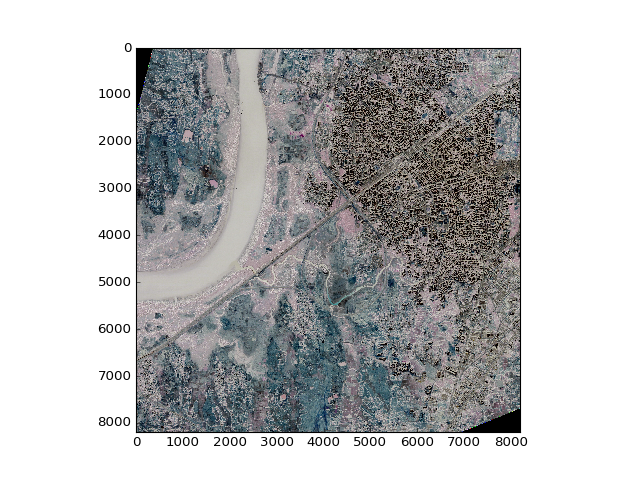

In [10]:
plt.figure()
plt.imshow(rgb_img)

In [11]:
segments_quick = quickshift(img, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

914492


<IPython.core.display.Javascript object>


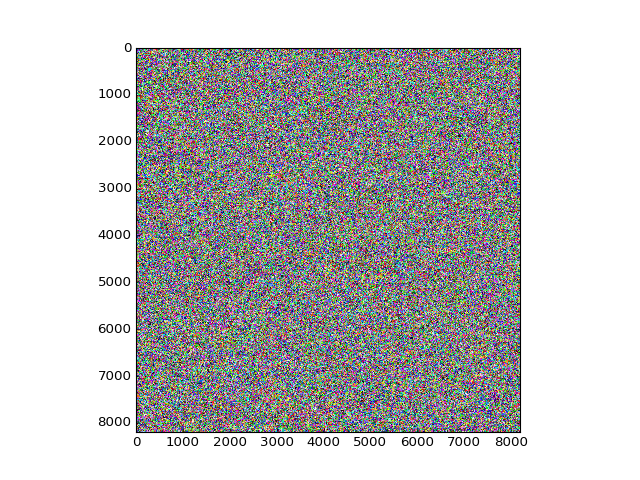

In [13]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

skimage.segmentation.felzenszwalb is not prepared to work with multi-band data. So, based on their own implementation for RGB images, I apply the segmentation in each band and then combine the results. See: http://github.com/scikit-image/scikit-image/blob/v0.12.3/skimage/segmentation/_felzenszwalb.py#L69

In [14]:
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9))

put pixels in same segment only if in the same segment in all bands. We do this by combining the band segmentation to one number


In [15]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

<IPython.core.display.Javascript object>


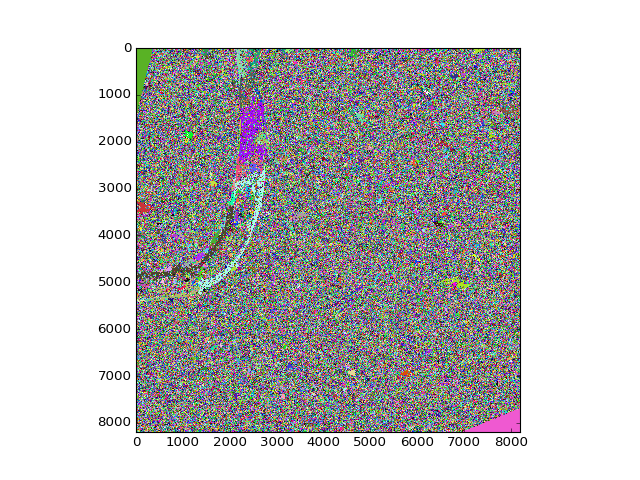

In [17]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

<IPython.core.display.Javascript object>


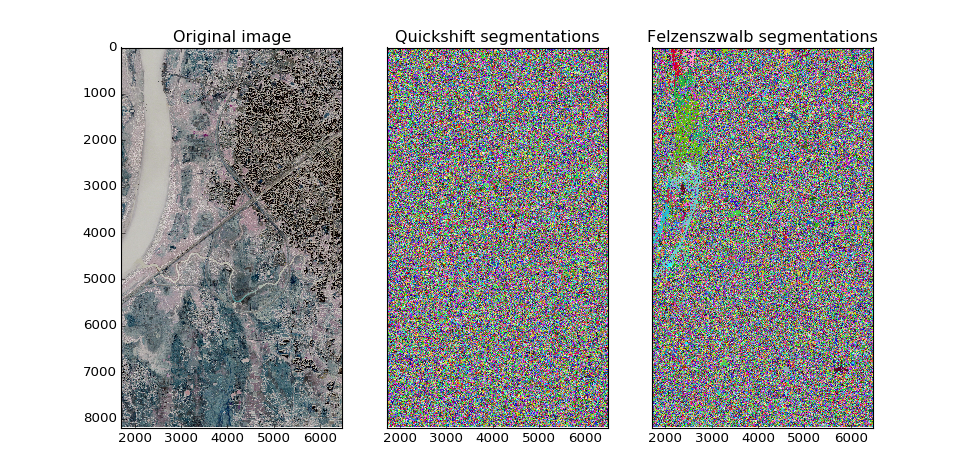

In [18]:
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

In [19]:
# We choose the Felzenszwalb segmentation
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 2709974 segments.


In [21]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

['/Users/droy/Desktop/data/train/A.shp', '/Users/droy/Desktop/data/train/B.shp', '/Users/droy/Desktop/data/train/C.shp', '/Users/droy/Desktop/data/train/D.shp', '/Users/droy/Desktop/data/train/E.shp']


In [22]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [23]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

5

In [ ]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

# Disambiguation
Check if there are segments which contain training pixels of different classes.

In [25]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

# No need to disambiguate!
Next, we will paint in black all segments that are not for training. The training segments will be painted of a color depending on the class.
To do that we'll set as threshold the max segment id (max segments image pixel value). Then, to the training segments we'll assign values higher than the threshold. Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [26]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

# Lets see the training segments¶


In [ ]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

# Training data
So now, we transform each training segment into a segment model and thus creating the training dataset.

In [28]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

# Create all the objects:
compute the features' vector for each segment (and append the segment ID as reference)

In [ ]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

# Subset the training data
Train a classifier

In [ ]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_objects, training_labels)


# Classify all segments
Now we have to transform all segments into a segment models in order to classify them

In [31]:
predicted = classifier.predict(objects)

# Propagate the classification
Now that each segment has been classified, we need to propagate that classification to the pixel level. That is, given the class k for the segment with label S, generate a classification from the segmented image where all pixels in segment S are assigned the class k.

In [32]:
clf = np.copy(segments)
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
ax2.set_title('Clasification')

# Classification validation


In [35]:
shapefiles = [os.path.join(TEST_DATA_PATH, "%s.shp"%c) for c in classes_labels]
verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)

verification_labels = verification_pixels[for_verification]
predicted_labels = clf[for_verification]

cm = metrics.confusion_matrix(verification_labels, predicted_labels)
from __future__ import print_function
def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

In [ ]:
print_cm(cm, classes_labels)


In [37]:
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification accuracy: 0.992911


In [ ]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=classes_labels))